In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2DTranspose, Dense, Reshape, Conv2D, MaxPool2D, Flatten, BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.layers import LeakyReLU, BatchNormalization, Dropout
from tqdm import tqdm_notebook

In [2]:
BATCH_SIZE = 1000
EPOCHS = 100
IMG_ROW = 28
IMG_COL = 28
IMG_SIZE = (IMG_ROW,IMG_COL,1)
NUM_LABELS = 10
LATENT_DIM = 100

In [3]:
(digits_train, label_train), (digits_test, label_test) = keras.datasets.mnist.load_data()

digits_train = (digits_train - 127.5) / 255.0
digits_test = (digits_test - 127.5) / 255.0

digits_train = np.reshape(digits_train, (digits_train.shape[0], digits_train.shape[1], digits_train.shape[2],1))
digits_test =np.reshape(digits_test, (digits_test.shape[0], digits_test.shape[1], digits_test.shape[2], 1))

label_train = keras.utils.to_categorical(label_train)
label_test = keras.utils.to_categorical(label_test)

In [4]:
gen = Sequential()
gen.add(Dense(4*4*32, activation='relu', input_dim=LATENT_DIM, name='inp_D'))
gen.add(Reshape((4,4,32)))
gen.add(Conv2DTranspose(32,(3,3), strides=(2,2), activation=LeakyReLU(alpha=0.2), padding='same', name='CT1'))
gen.add(Conv2DTranspose(64,(3,3), activation=LeakyReLU(alpha=0.2), name='CT2'))
gen.add(Conv2DTranspose(64,(3,3), activation=LeakyReLU(alpha=0.2), name='CT3'))
gen.add(Conv2DTranspose(64,(3,3), activation=LeakyReLU(alpha=0.2), name='CT4'))
gen.add(Conv2DTranspose(1,(2,2), padding='same', strides=(2,2), activation='tanh', name='CT5'))
gen.compile(optimizer=keras.optimizers.Adam(lr=0.002, beta_1=0.5),
            loss='binary_crossentropy')

disc = Sequential(name = 'disc')
disc.add(keras.Input(shape=IMG_SIZE))
disc.add(Conv2D(32, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), strides=(2,2), name='C1'))
disc.add(Conv2D(64, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), strides=(2,2), name='C2'))
disc.add(Conv2D(32, (3,3), padding='same', activation=LeakyReLU(alpha=0.2), strides=(2,2), name='C3'))
disc.add(Flatten(name='F'))
disc.add(Dense(64, activation=LeakyReLU(alpha=0.2), name='D1'))
disc.add(Dense(1, activation='sigmoid', name='D2'))
disc.compile(optimizer=keras.optimizers.Adam(lr=0.002, beta_1=0.5),
            loss='binary_crossentropy')


disc.trainable = False
inputs = keras.Input(shape=(LATENT_DIM, ))
hidden = gen(inputs)
output = disc(hidden)
gan = Model(inputs, output, name='GAN')
gan.compile(optimizer=keras.optimizers.Adam(lr=0.002, beta_1=0.5), 
            loss='binary_crossentropy')    

C:\Users\WorkStation\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
gen.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inp_D (Dense)               (None, 512)               51712     
                                                                 
 reshape (Reshape)           (None, 4, 4, 32)          0         
                                                                 
 CT1 (Conv2DTranspose)       (None, 8, 8, 32)          9248      
                                                                 
 CT2 (Conv2DTranspose)       (None, 10, 10, 64)        18496     
                                                                 
 CT3 (Conv2DTranspose)       (None, 12, 12, 64)        36928     
                                                                 
 CT4 (Conv2DTranspose)       (None, 14, 14, 64)        36928     
                                                                 
 CT5 (Conv2DTranspose)       (None, 28, 28, 1)         2

In [6]:
disc.summary()

Model: "disc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 C1 (Conv2D)                 (None, 14, 14, 32)        320       
                                                                 
 C2 (Conv2D)                 (None, 7, 7, 64)          18496     
                                                                 
 C3 (Conv2D)                 (None, 4, 4, 32)          18464     
                                                                 
 F (Flatten)                 (None, 512)               0         
                                                                 
 D1 (Dense)                  (None, 64)                32832     
                                                                 
 D2 (Dense)                  (None, 1)                 65        
                                                                 
Total params: 70,177
Trainable params: 0
Non-trainable params:

In [7]:
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         153569    
                                                                 
 disc (Sequential)           (None, 1)                 70177     
                                                                 
Total params: 223,746
Trainable params: 153,569
Non-trainable params: 70,177
_________________________________________________________________


In [8]:
gan.get_layer('disc').weights[-2][:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.2098651 ],
       [-0.21803088],
       [-0.27918518],
       [-0.01403368],
       [-0.21306448]], dtype=float32)>

In [9]:
disc.get_layer('D2').weights[0][:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.2098651 ],
       [-0.21803088],
       [-0.27918518],
       [-0.01403368],
       [-0.21306448]], dtype=float32)>

In [22]:
def plotting(imgs=None):
    if imgs is None:
        imgs = gen.predict(np.random.normal(0, 1, (5, LATENT_DIM)))
    plt.figure(figsize=(15,3))
    for i in range(1,6):
        plt.subplot(1, 5, i).imshow(imgs[i-1], cmap='gray')
    plt.show()

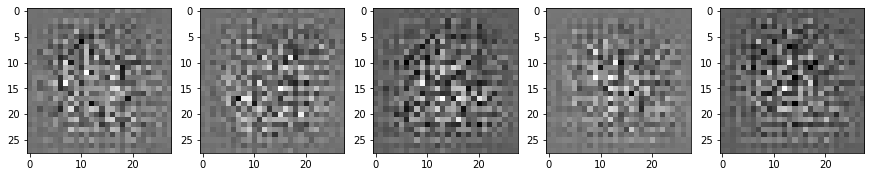

In [11]:
plotting()

In [12]:
def train(epochs=10, BATH_SIZE=100):
    for epoch in tqdm_notebook(range(epochs+1)):
#         print(f'epoch {epoch}')
#         print(disc.get_layer('D2').weights[0][:5])
#         print(gan.get_layer('disc').weights[-2][:5])
        for _ in range(100):
            image_batch = digits_train[np.random.randint(0, digits_train.shape[0], size=BATCH_SIZE)]
            
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, LATENT_DIM))
            
            generated_images = gen.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing
            
            disc.trainable = True
            d_loss = disc.train_on_batch(X, y)
            
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, LATENT_DIM))
            y2 = np.ones(BATCH_SIZE)
            disc.trainable = False
            gan_loss = gan.train_on_batch(noise, y2)
        
        if epoch%10 == 0:
            print(f'-------------------epoch {epoch}-------------------')
            print(f'd_loss {d_loss} gan_loss {gan_loss}')
            print(disc.get_layer('D2').weights[0][:5])
            plotting()


C:\Users\WORKST~1\AppData\Local\Temp/ipykernel_20192/1652784395.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs+1)):


  0%|          | 0/21 [00:00<?, ?it/s]

-------------------epoch 0-------------------
d_loss 0.5411182045936584 gan_loss 2.9718923568725586
tf.Tensor(
[[ 0.19254224]
 [-0.24923031]
 [-0.28219324]
 [-0.01612113]
 [-0.23857976]], shape=(5, 1), dtype=float32)


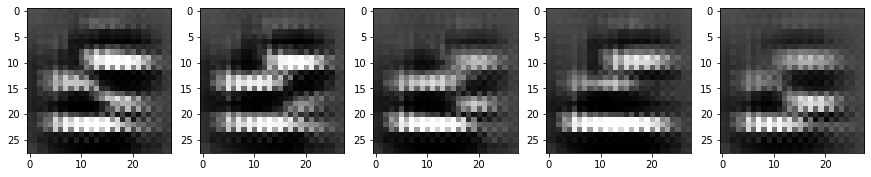

-------------------epoch 10-------------------
d_loss 0.49517056345939636 gan_loss 2.1396641731262207
tf.Tensor(
[[ 0.17512988]
 [-0.28942573]
 [-0.35235116]
 [-0.13563728]
 [-0.34839705]], shape=(5, 1), dtype=float32)


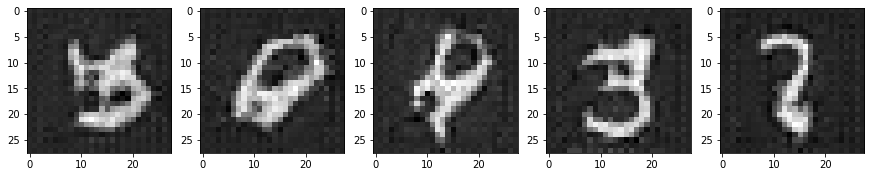

-------------------epoch 20-------------------
d_loss 0.5459029078483582 gan_loss 1.5106525421142578
tf.Tensor(
[[ 0.16296653]
 [-0.3244184 ]
 [-0.3747197 ]
 [-0.23471461]
 [-0.50003064]], shape=(5, 1), dtype=float32)


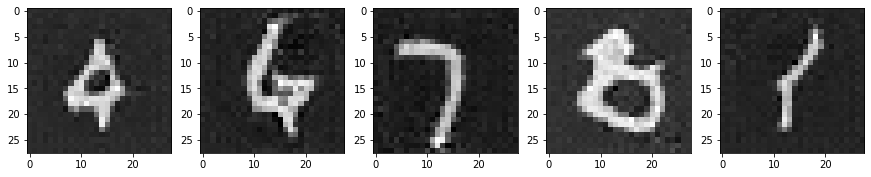

In [13]:
train(epochs=20, BATH_SIZE=100)


C:\Users\WORKST~1\AppData\Local\Temp/ipykernel_20192/1652784395.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(epochs+1)):


  0%|          | 0/51 [00:00<?, ?it/s]

-------------------epoch 0-------------------
d_loss 0.19303028285503387 gan_loss 4.357702255249023
tf.Tensor(
[[ 0.16059148]
 [-0.32181624]
 [-0.3720772 ]
 [-0.23141643]
 [-0.49726415]], shape=(5, 1), dtype=float32)


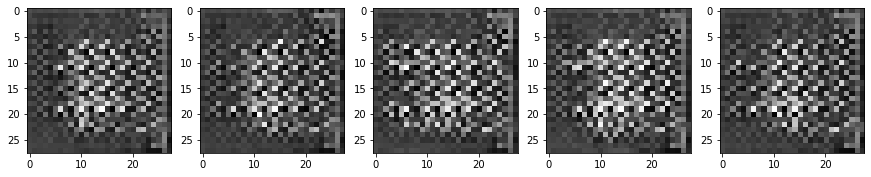

-------------------epoch 10-------------------
d_loss 0.43627774715423584 gan_loss 1.458691120147705
tf.Tensor(
[[ 0.16264991]
 [-0.37561885]
 [-0.3901991 ]
 [-0.26417196]
 [-0.5543533 ]], shape=(5, 1), dtype=float32)


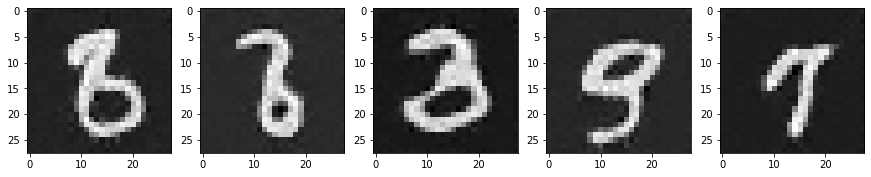

-------------------epoch 20-------------------
d_loss 0.4959876239299774 gan_loss 1.2518305778503418
tf.Tensor(
[[ 0.16896312]
 [-0.41282535]
 [-0.42379677]
 [-0.30774298]
 [-0.6113427 ]], shape=(5, 1), dtype=float32)


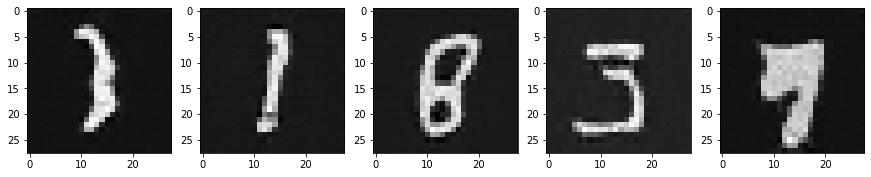

-------------------epoch 30-------------------
d_loss 0.5256096124649048 gan_loss 1.1605989933013916
tf.Tensor(
[[ 0.1824694 ]
 [-0.43862122]
 [-0.45201802]
 [-0.3412699 ]
 [-0.64376396]], shape=(5, 1), dtype=float32)


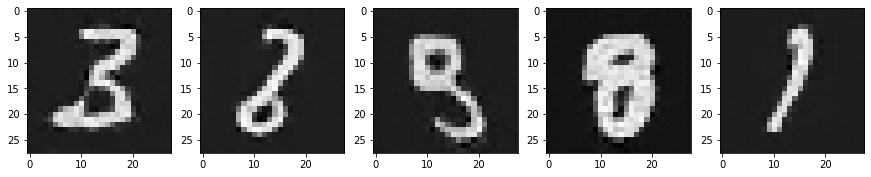

-------------------epoch 40-------------------
d_loss 0.5322960019111633 gan_loss 1.3393878936767578
tf.Tensor(
[[ 0.19700134]
 [-0.46188277]
 [-0.47322664]
 [-0.36380544]
 [-0.657801  ]], shape=(5, 1), dtype=float32)


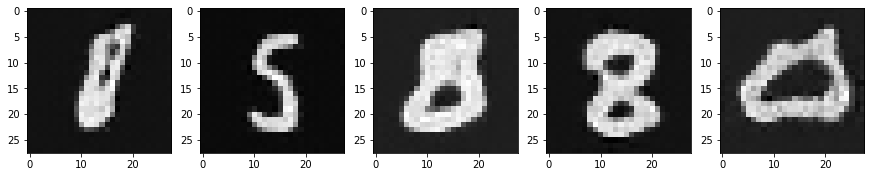

-------------------epoch 50-------------------
d_loss 0.545041024684906 gan_loss 1.3258308172225952
tf.Tensor(
[[ 0.21867034]
 [-0.4796153 ]
 [-0.49062562]
 [-0.37955076]
 [-0.66779894]], shape=(5, 1), dtype=float32)


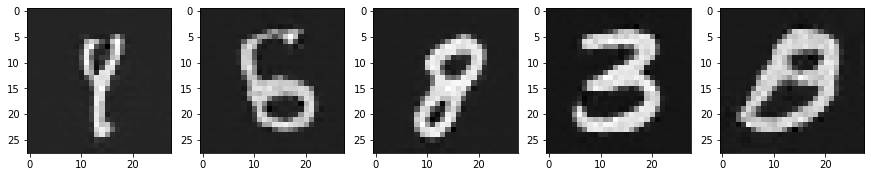

In [15]:
gen.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
            loss='binary_crossentropy')

disc.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),
            loss='binary_crossentropy')
disc.trainable = False
gan.compile(optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5), 
            loss='binary_crossentropy')    
train(epochs=50, BATH_SIZE=100)

In [16]:
gen.save('gen')
disc.save('disc')
gan.save('gan')

INFO:tensorflow:Assets written to: gen\assets


INFO:tensorflow:Assets written to: gen\assets


INFO:tensorflow:Assets written to: disc\assets


INFO:tensorflow:Assets written to: disc\assets


INFO:tensorflow:Assets written to: gan\assets


INFO:tensorflow:Assets written to: gan\assets


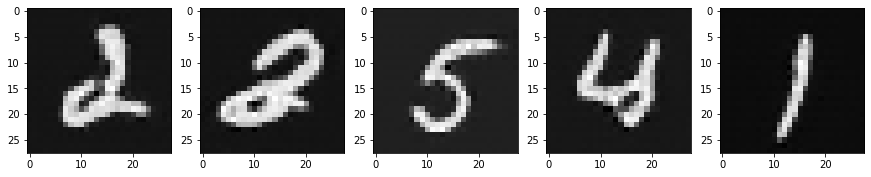

In [18]:
plotting()

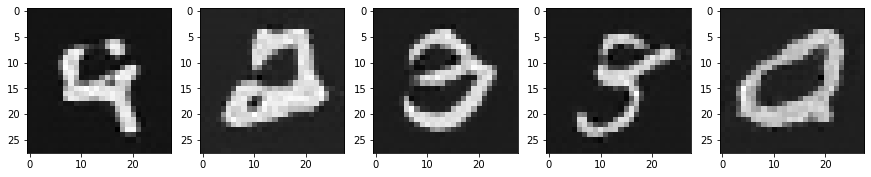

array([[0.4104044 ],
       [0.40750748],
       [0.21686305],
       [0.41659322],
       [0.7585782 ]], dtype=float32)

In [26]:
gen_imgs = gen.predict(np.random.normal(0, 1, (5, LATENT_DIM)))
plotting(gen_imgs)
disc.predict(gen_imgs)

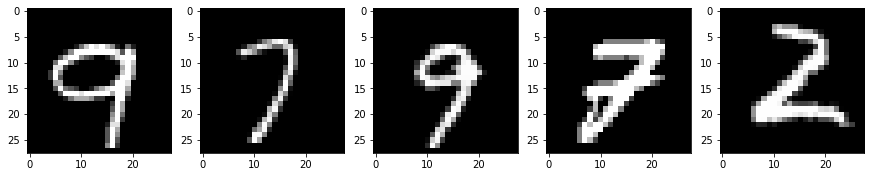

array([[0.6410465 ],
       [0.89928615],
       [0.68147945],
       [0.43439832],
       [0.63829535]], dtype=float32)

In [27]:
real_imgs = digits_test[np.random.randint(0, digits_test.shape[0],5)]
plotting(real_imgs)
disc.predict(real_imgs)